In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import kid_readout.roach.heterodyne
import time
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil
import kid_readout.utils.data_file
import kid_readout.equipment.agilent_33220

In [3]:
fg = kid_readout.equipment.agilent_33220.FunctionGenerator(addr=('192.168.1.145', 5025))

In [4]:
fg.send_get('*IDN?')

'Agilent Technologies,33220A,MY44058488,2.07-2.06-22-2\n'

In [5]:
fg.enable_output(False)

In [6]:
fg.set_load_ohms(1e6)

In [7]:
ri = kid_readout.roach.heterodyne.RoachHeterodyne()

In [8]:
all_resonances = np.array([1221.0, # double
                           1226.16,
                           1227.47,
                           1237.0,
                           1248.15,
                           1251.75, # double
                           1263.95,
                           1268.72,
                           1275.42,
                           1283.17,
                           1288.82,
                           1291.35,
                           1297.74,
                           1304.04,
                           1305.1,
                           1310.07,
                           1318.5,
                           1346.3,
                           1352.14,
                           1356.16,
                           1359.64,
                           1368.88,
                           1372.6,
                           1385.75,
                           1387.4,
                           1389.44,
                           1402.13, #double
                           1418.13,
                           1426.35,
                           1434.95,
                           1437.93,
                           1444.92,
                           1452.59,
                           
                           
             ])

In [9]:
all_resonances.shape

(33,)

In [10]:
initial_f0s = all_resonances[1:33]
initial_f0s.sort()
initial_f0s,initial_f0s.shape

(array([ 1226.16,  1227.47,  1237.  ,  1248.15,  1251.75,  1263.95,
         1268.72,  1275.42,  1283.17,  1288.82,  1291.35,  1297.74,
         1304.04,  1305.1 ,  1310.07,  1318.5 ,  1346.3 ,  1352.14,
         1356.16,  1359.64,  1368.88,  1372.6 ,  1385.75,  1387.4 ,
         1389.44,  1402.13,  1418.13,  1426.35,  1434.95,  1437.93,
         1444.92,  1452.59]), (32,))

In [11]:
initial_f0s = array([ 1219.8359375,  1221.1796875,  1225.640625 ,  1227.0546875,
        1236.9609375,  1247.2421875,  1252.0078125,  1264.0625   ,
        1268.578125 ,  1275.1953125,  1278.4921875,  1288.0078125,
        1289.71875  ,  1295.5625   ,  1302.078125 ,  1303.5625   ,
        1306.671875 ,  1311.6796875,  1349.9765625,  1355.4921875,
        1359.1328125,  1369.1640625,  1371.125    ,  1385.7109375,
        1389.2890625,  1398.0078125,  1401.9765625,  1426.34375  ,
        1429.3203125,  1437.1015625,  1442.3203125,  1450.2578125])

In [12]:
initial_atten = 3
atten_levels = [3]#[30,15,10,6,3,0]

In [13]:
ri.set_lo(1330)

In [14]:
ri.set_fft_gain(4)

In [15]:
ri.lo_frequency

1330

In [16]:
import kid_readout.utils.sweeps
reload(kid_readout.utils.sweeps)

<module 'kid_readout.utils.sweeps' from '/home/gjones/readout/kid_readout/kid_readout/utils/sweeps.pyc'>

In [17]:
nsamp = 2**16
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s,offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[ 1219.3359375,  1220.6796875,  1225.140625 , ...,  1436.6015625,
         1441.8203125,  1449.7578125],
       [ 1219.34375  ,  1220.6875   ,  1225.1484375, ...,  1436.609375 ,
         1441.828125 ,  1449.765625 ],
       [ 1219.3515625,  1220.6953125,  1225.15625  , ...,  1436.6171875,
         1441.8359375,  1449.7734375],
       ..., 
       [ 1220.3125   ,  1221.65625  ,  1226.1171875, ...,  1437.578125 ,
         1442.796875 ,  1450.734375 ],
       [ 1220.3203125,  1221.6640625,  1226.125    , ...,  1437.5859375,
         1442.8046875,  1450.7421875],
       [ 1220.328125 ,  1221.671875 ,  1226.1328125, ...,  1437.59375  ,
         1442.8125   ,  1450.75     ]])

In [18]:
ri.set_dac_atten(initial_atten)

In [19]:
fg.set_dc_voltage(0)
fg.enable_output(True)

In [20]:
data_file = kid_readout.utils.data_file.DataFile(suffix='irled')

In [21]:
data_file.log_adc_snap(ri)
data_file.log_hw_state(ri)

In [22]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
print time.time()-tic
data_file.add_sweep(swp)

detected mcnt overflow None 1900634 0 32768 0 304 1900634
detected mcnt overflow None 458770 0 32768 0 32 458770
detected mcnt overflow None 1867796 0 32768 0 224 1867796
133.338108063


'sweep_20150713132609'

In [23]:
def fit_sweeps(swp):
    resonators = []
    lo = swp.blocks[0].lo
    fig,axs = subplots(8,4,figsize=(18,12))
    fig2,axs2 = subplots(8,4,figsize=(18,12))
    for k in range(swp.sweep_indexes.max()+1):
        fr,s21,err = swp.select_index(k)
        ax = axs.flatten()[k]
        fr,s21,err = swp.select_index(k)
        s21c = s21*np.exp(swp.hardware_delay_estimate*1e6j*2*np.pi*(fr-swp.lo[0]))
        res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
        ax.plot(s21c.real,s21c.imag,'.-')
        modl = res.model(x=fr)
        ax.plot(modl.real,modl.imag,'.-')
        ax2 = axs2.flatten()[k]
        ax2.plot(fr,20*np.log10(np.abs(s21c)),'.-')
        ax2.plot(fr,20*np.log10(np.abs(modl)),'.-')
        resonators.append(res)
    return resonators

In [24]:
np.unique(swp.sweep_indexes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

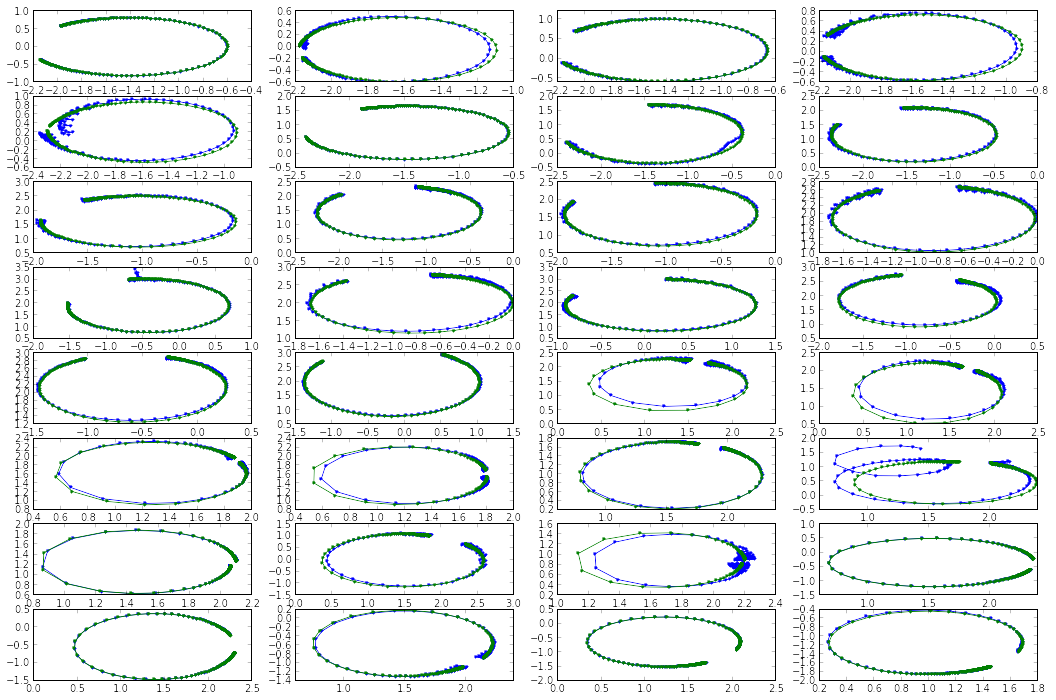

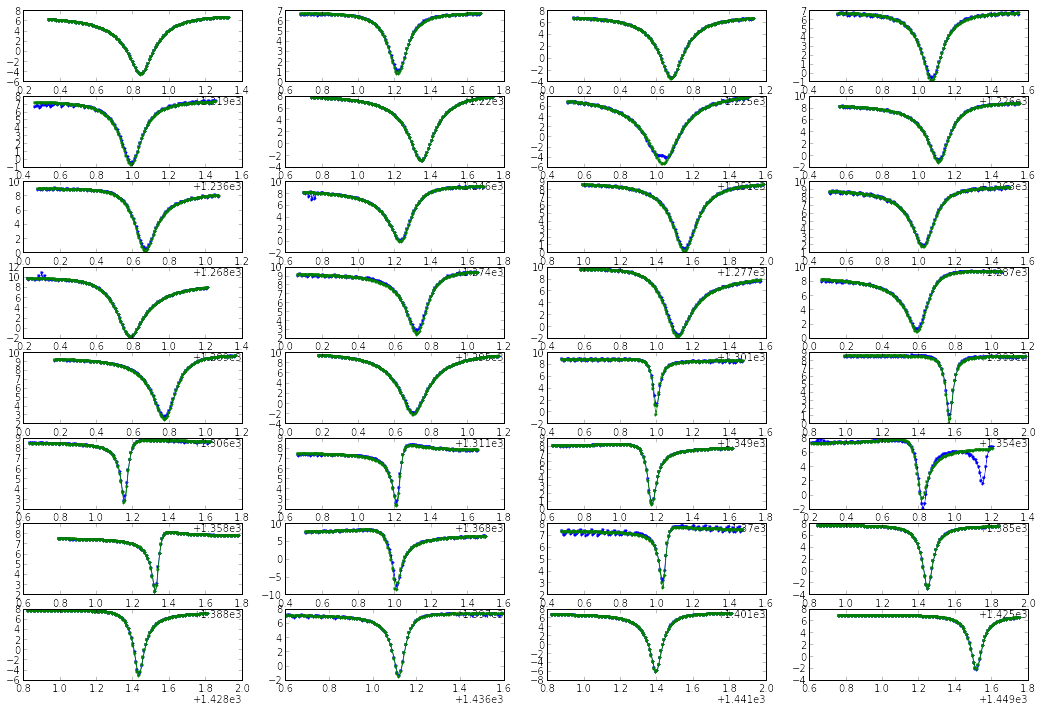

In [25]:
resonators = fit_sweeps(swp)

In [26]:
updated_f0s = np.array([res.f_0 for res in resonators])
Qs = np.array([res.Q for res in resonators])
fwhm = updated_f0s/(2*Qs)
(updated_f0s - initial_f0s)*1e3

array([  24.99022755,   35.70197065,   40.30673468,   16.14308569,
         31.10051626,  117.09860613,   58.51572599,   64.61063469,
         64.40479783,   68.98423475,   62.95610376,   32.98327126,
         13.6167049 ,  173.88317053,  -21.23400329,   66.17923884,
        119.54590529,   19.4486236 ,   10.5803086 ,   70.77839856,
         26.2241065 ,   57.5843051 ,   33.10065407,   78.94876914,
         43.73123683,  -40.00715921,   60.54097436,   98.72988363,
         95.85485396,   22.81502577,   82.44329406,  252.51142746])

In [27]:
updated_f0s

array([ 1219.86092773,  1221.21538947,  1225.68093173,  1227.07083059,
        1236.99203802,  1247.35928611,  1252.06632823,  1264.12711063,
        1268.6425298 ,  1275.26429673,  1278.5551436 ,  1288.04079577,
        1289.7323667 ,  1295.73638317,  1302.056891  ,  1303.62867924,
        1306.79142091,  1311.69913612,  1349.98714281,  1355.5629659 ,
        1359.15903661,  1369.22164681,  1371.15810065,  1385.78988627,
        1389.33279374,  1397.96780534,  1402.03710347,  1426.44247988,
        1429.41616735,  1437.12437753,  1442.40275579,  1450.51032393])

In [28]:
fwhm

array([ 0.18037931,  0.08642204,  0.15460926,  0.10727473,  0.11361131,
        0.16731308,  0.24947009,  0.12896399,  0.11591292,  0.12371177,
        0.13648017,  0.11652694,  0.17494126,  0.10305706,  0.16262689,
        0.10896851,  0.11413964,  0.20108513,  0.03038679,  0.03377077,
        0.03098582,  0.02937051,  0.04288329,  0.04964683,  0.02806837,
        0.06837335,  0.02424966,  0.06344537,  0.07402759,  0.05500976,
        0.08973859,  0.06533977])

In [29]:
nsamp = 2**18
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=updated_f0s,offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0

writing DRAM bank 1



array([[ 1219.73632812,  1221.08984375,  1225.55664062, ...,
         1437.        ,  1442.27734375,  1450.38476562],
       [ 1219.73828125,  1221.09179688,  1225.55859375, ...,
         1437.00195312,  1442.27929688,  1450.38671875],
       [ 1219.74023438,  1221.09375   ,  1225.56054688, ...,
         1437.00390625,  1442.28125   ,  1450.38867188],
       ..., 
       [ 1219.98046875,  1221.33398438,  1225.80078125, ...,
         1437.24414062,  1442.52148438,  1450.62890625],
       [ 1219.98242188,  1221.3359375 ,  1225.80273438, ...,
         1437.24609375,  1442.5234375 ,  1450.63085938],
       [ 1219.984375  ,  1221.33789062,  1225.8046875 , ...,
         1437.24804688,  1442.52539062,  1450.6328125 ]])

detected mcnt overflow None 1605725 0 32768 0 32 1605725
detected mcnt overflow None 557150 0 32768 0 256 557150
detected mcnt overflow None 163934 0 32768 0 432 163934
detected mcnt overflow None 426001 0 32768 0 176 426001
133.314424992


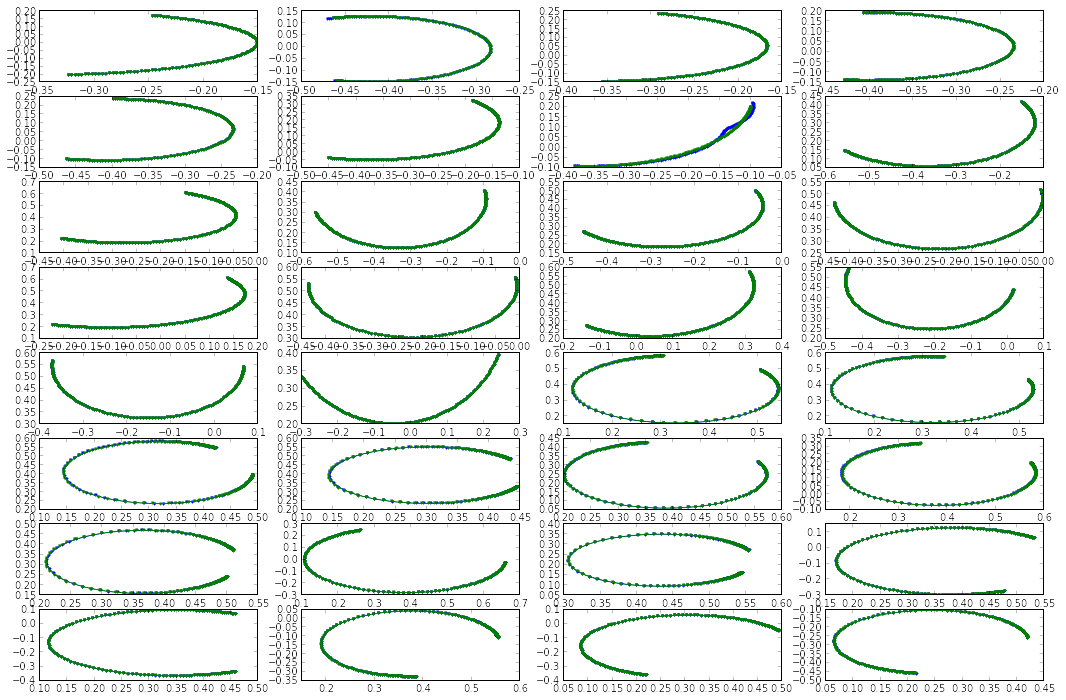

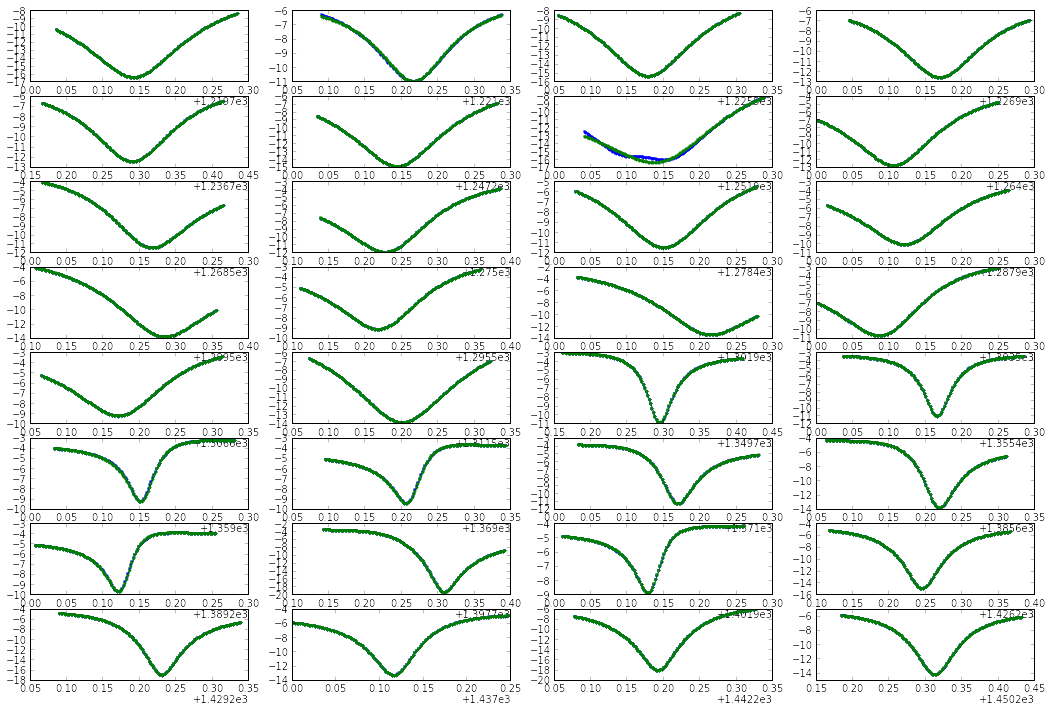

In [30]:
tic = time.time()
fine_swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
print time.time()-tic
new_res = fit_sweeps(fine_swp)
new_f0s = np.array([res.f_0 for res in new_res])

In [31]:
ri.add_tone_freqs(new_f0s)

bank_offset= 2 start_offset= 67108864 start_offset_bytes= 0
writing DRAM bank 2



array([ 1219.86132812,  1221.21875   ,  1225.68164062,  1227.0703125 ,
        1236.99414062,  1247.359375  ,  1252.13476562,  1264.12695312,
        1268.64453125,  1275.26171875,  1278.55664062,  1288.0390625 ,
        1289.734375  ,  1295.73828125,  1302.06054688,  1303.625     ,
        1306.79296875,  1311.70117188,  1349.99023438,  1355.56640625,
        1359.16015625,  1369.22070312,  1371.16015625,  1385.8046875 ,
        1389.33398438,  1397.97265625,  1402.03710938,  1426.4453125 ,
        1429.41796875,  1437.125     ,  1442.40429688,  1450.51171875])

atten 3
detected mcnt overflow None 1212510 0 32768 0 240 1212510
detected mcnt overflow None 1081361 0 32768 0 192 1081361
134.317159891
difference in resonant frequency, ppm: [ 0.00971847 -0.04655897  0.02845676 -0.04420175  0.00844336  0.00986193
  0.5964846   0.03739308 -0.02201961  0.00553593  0.00121753  0.05357277
 -0.04689814  0.01881553 -0.04246802  0.00669371  0.00987287 -0.05196408
 -0.00865254  0.00808419  0.17650862  0.00535551 -0.00956666  0.02567963
  0.00959207 -0.00123956  0.00423262 -0.00211291  0.02616507  0.01291933
  0.00673568  0.00342054]
173.338159084
getting data with LED on
186.394869089
getting data with LED on
detected mcnt overflow None 557150 0 65536 0 11264 557150
199.672261953
getting data with LED on
detected mcnt overflow None 557150 0 65536 0 24928 557150
212.895903111
getting data with LED on
226.110965014
getting data with LED on
239.403659105
getting data with LED on
detected mcnt overflow None 557150 0 65536 0 800 557150
252.61716795
getting data 

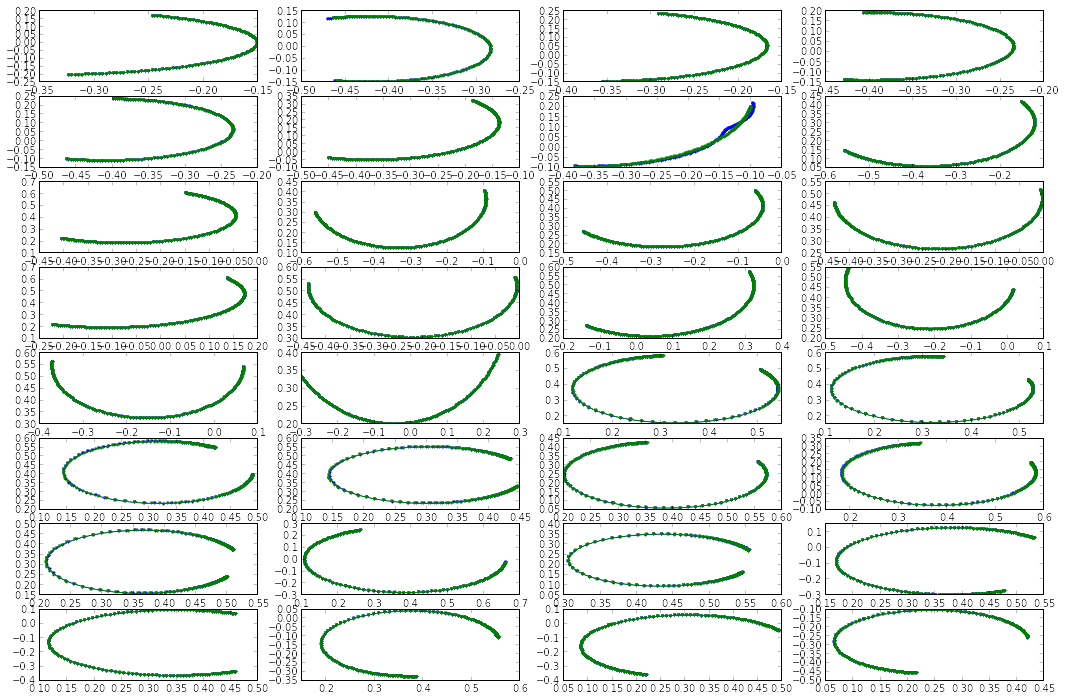

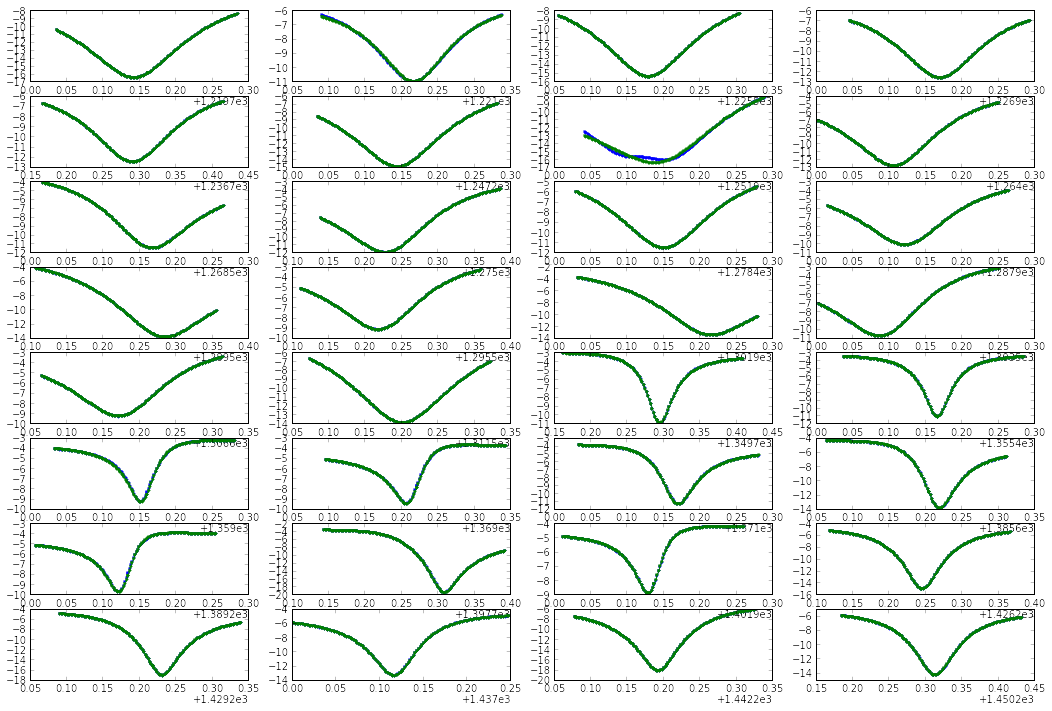

In [32]:
sweeps = []
for atten in atten_levels:
    ri.set_dac_atten(atten)
    data_file.log_adc_snap(ri)
    data_file.log_hw_state(ri)
    print "atten",atten
    tic = time.time()
    fine_swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
    print time.time()-tic
    sweeps.append(fine_swp)
    data_file.add_sweep(fine_swp)
    resonators = fit_sweeps(fine_swp)
    fit_f0s = np.array([res.f_0 for res in resonators])
    print "difference in resonant frequency, ppm:",(1e6*(new_f0s-fit_f0s)/new_f0s)
    ri.select_bank(ri.tone_bins.shape[0]-1)
    ri.select_fft_bins(range(ri.fft_bins.shape[1]))
    ri._sync()
    time.sleep(1)
    t0 = time.time()
    d,addr = ri.get_data(64)
    tsg = data_file.add_timestream_data(d,ri,t0)
    print time.time()-tic
    for voltage in [4.0,5.0,6.0,7.0,8.0,9.0,10.0]:
        print "getting data with LED on"
        fg.set_dc_voltage(voltage)
        fg.enable_output(True)
        time.sleep(1)
        t0 = time.time()
        d,addr = ri.get_data(64)
        tsg = data_file.add_timestream_data(d,ri,t0,zbd_voltage=voltage)
        print time.time()-tic
        fg.set_dc_voltage(0.0)
    

In [33]:
data_file.close()

In [34]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

using NFFT: 2** 15.0
10

/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  Pxx[:,i] = np.conjugate(fx[:numFreqs]) * fx[:numFreqs]
/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:174: ComplexWarning: Casting complex values to real discards the imaginary part
  Pyy[:,i] = np.conjugate(fy[:numFreqs]) * fy[:numFreqs]
/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  S[0,k] = ss[0,0]



using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10
using NFFT: 2** 15.0
10


/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  S[1,k] = ss[1,1]


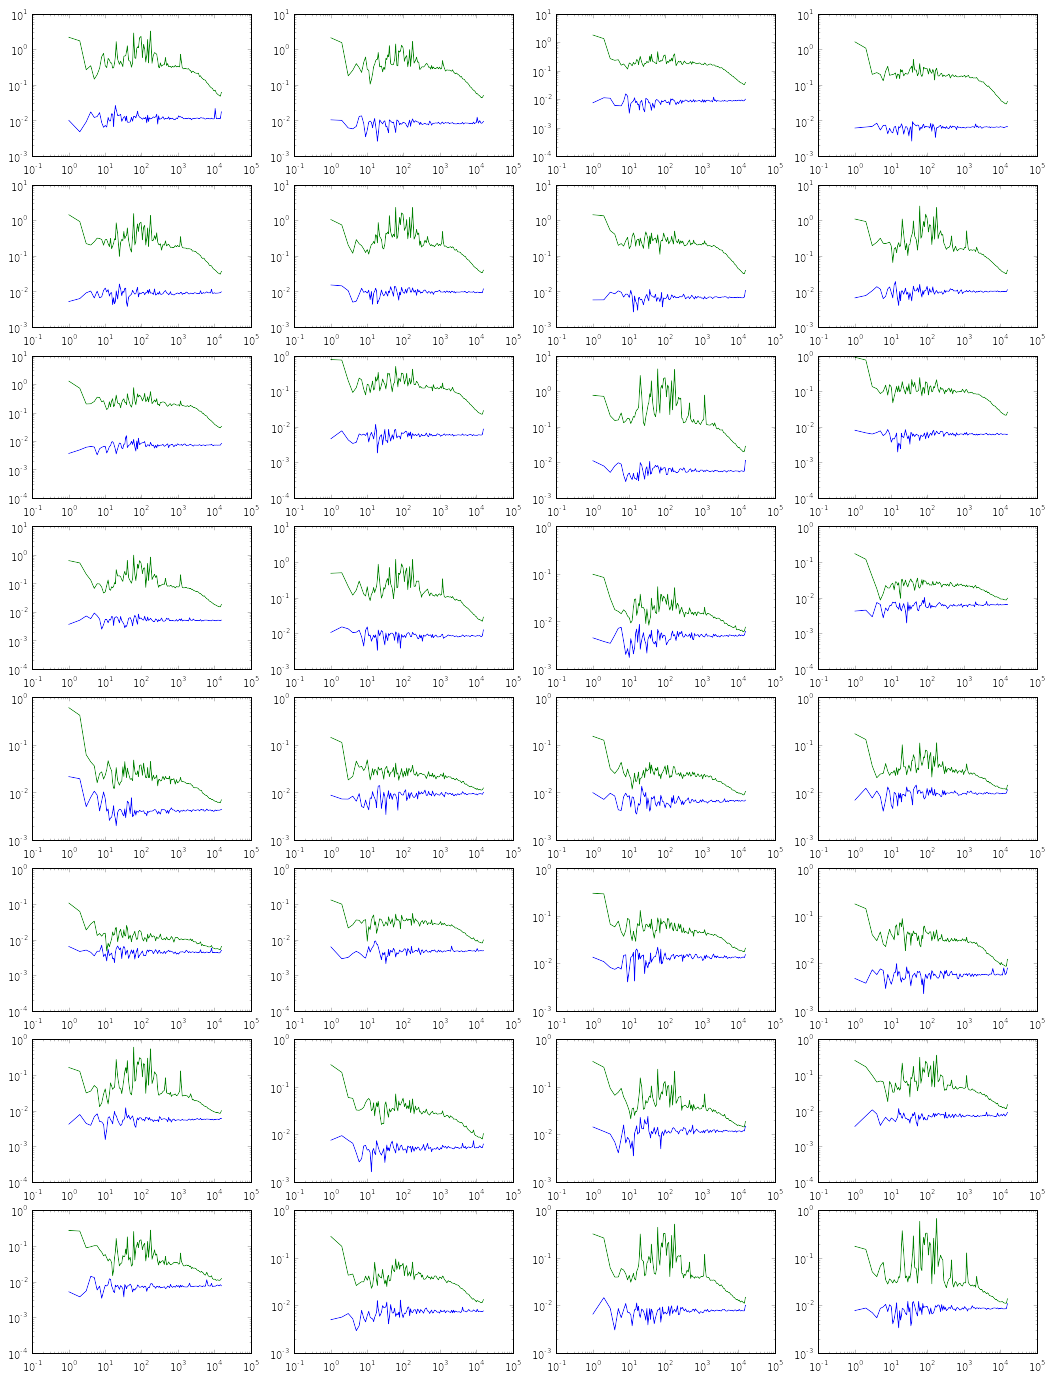

In [35]:
dmod=d
fig,axs = subplots(8,4,figsize=(18,24))
for k in range(32):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)

In [36]:
fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(dmod[:,0]-dmod[:,0].mean(),Fs=512e6/2**14,use_log_bins=False,use_full_spectral_helper=True)

#ax.loglog(fr,evals.T)

using NFFT: 2** 15.0


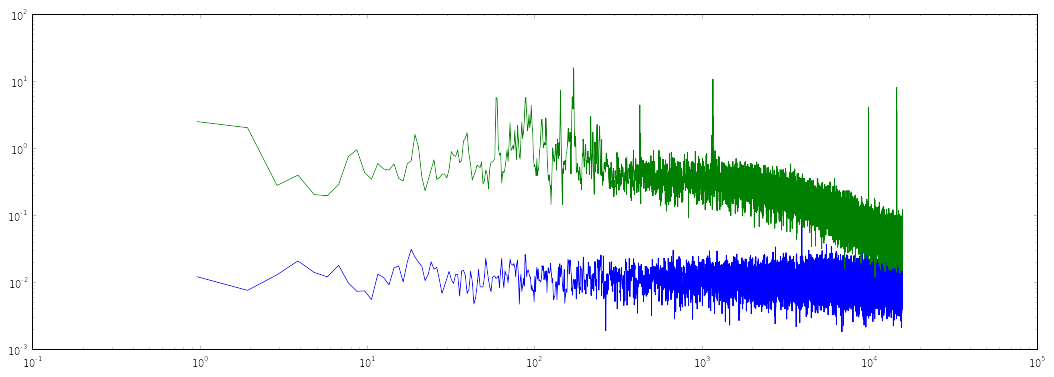

In [37]:
figure(figsize=(18,6))
loglog(fr,evals.T)

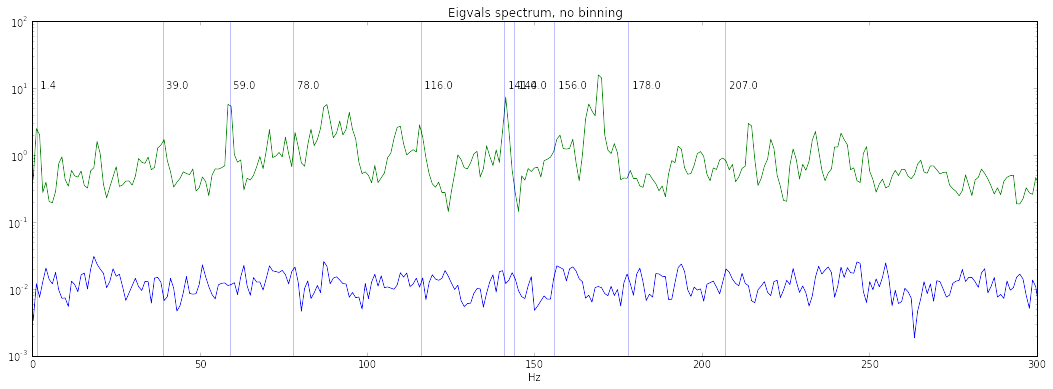

In [38]:
figure(figsize=(18,6))
semilogy(fr,evals.T)
xlim(0,300)
ax = gca()
for spur in [1.4,39,59,78,116,141,144,156,178,207]:
    ax.text(spur,10,(' %.1f' % spur))
    ax.axvline(spur,alpha=0.5)
xlabel('Hz')
title('Eigvals spectrum, no binning')

In [40]:
2

2

In [39]:
fg.enable_output(False)

(0, 300)

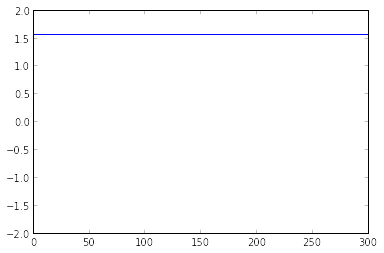

In [50]:
plot(fr,angles[0,:]-angles[1,:])
xlim(0,300)

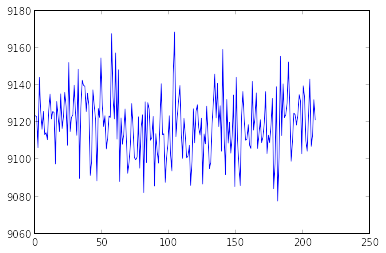

In [65]:
plot(dmod[::10000,0].imag)

In [34]:
[x.Q for x in resonators]

[5530.4204148254321,
 6510.3534008925653,
 4485.3100238556599,
 4987.9055398172059,
 6558.4197686496818,
 6689.5209862954944,
 4582.5894108131315,
 6855.0975380227137,
 5369.6667007546721,
 6335.6681161957913,
 2866.5493420870771,
 6267.436323946773,
 7799.667467864313,
 3664.6376472682095,
 6837.6014569421213,
 3309.7455378011678,
 23995.905051841237,
 16872.167905415681,
 17819.926273214827,
 22971.192316145749,
 22177.561470257955,
 12937.974859938417,
 20991.732389766814,
 11410.587577931896,
 26421.835839896547,
 6562.0849274461434,
 29443.11898784191,
 10882.958699017787,
 10666.48271589865,
 12871.174575511679,
 7441.1505216293026,
 11548.369943805703]

In [29]:
ri.tone_bins.shape

(129, 16)

In [ ]:
new_res = fit_sweeps(fine_swp)

In [46]:
fr,s21,err = fine_swp.select_index(0)
fr.ptp()

0.1240234375

In [47]:
new_f0s = np.array([res.f_0 for res in new_res])
newQs = np.array([res.Q for res in new_res])
fwhm = new_f0s/(2*newQs)
(new_f0s - initial_f0s)*1e3

array([ -2.75036198,  -8.36499499, -18.1566517 ,  27.45684   ,
        29.52417282,   6.18154885,  62.34624514,  -7.40309064,
        44.37014026,  -3.04533981,  11.30370433, -10.9906153 ,
        13.04140384, -44.33065046,  19.85448771,   7.9253936 ])

In [48]:
fwhm

array([ 0.02912425,  0.03078778,  0.02714933,  0.0302079 ,  0.02514165,
        0.02601062,  0.03599471,  0.02899567,  0.02582677,  0.02677329,
        0.03062127,  0.03108903,  0.01615045,  0.01502604,  0.01341793,
        0.01315327])

In [49]:
[res.delay for res in new_res]

[0.45141720942144958,
 0.094586777665206123,
 0.014686151981272174,
 0.017796887808216814,
 0.00043724074656971993,
 0.011191579245233058,
 0.0094185496420942927,
 0.05758960001641613,
 -0.0033176609419354351,
 0.007291893632622024,
 0.0079508120551642324,
 -0.00077998325721197539,
 0.0041570727965430238,
 0.00093343481198936889,
 -0.00047656048102172777,
 0.011198239856341578]

In [50]:
newQs

array([ 14505.90628717,  14051.54439249,  16057.1507388 ,  14488.21970183,
        17494.86702526,  16935.31803672,  12267.80757015,  15367.16899379,
        17442.06407264,  16906.71882743,  14983.23560798,  14786.38738301,
        29272.02800418,  31527.12783064,  35416.04611583,  36629.2168434 ])

In [51]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

In [52]:
new_f0s

array([ 844.94724964,  865.23163501,  871.88184335,  875.31745684,
        879.69952417,  880.99618155,  883.15234625,  891.16259691,
        900.94437014,  905.29695466,  917.6113037 ,  919.38900938,
        945.5130414 ,  947.45566935,  950.41985449,  963.58792539])

In [53]:
ri.set_tone_freqs(new_f0s,nsamp=2**18)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([ 844.94726562,  865.23242188,  871.8828125 ,  875.31835938,
        879.69921875,  880.99609375,  883.15234375,  891.16210938,
        900.9453125 ,  905.296875  ,  917.61132812,  919.38867188,
        945.51367188,  947.45507812,  950.41992188,  963.58789062])

In [55]:
ri.select_fft_bins(range(16))

In [64]:
ri.set_dac_atten(10)

In [65]:
dmod,addr = ri.get_data(128)

detected mcnt overflow None 1310485 0 32768 0 26224 1310485


In [57]:
dmod.shape

(524288, 16)

In [26]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

In [30]:
dmod = d

using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10


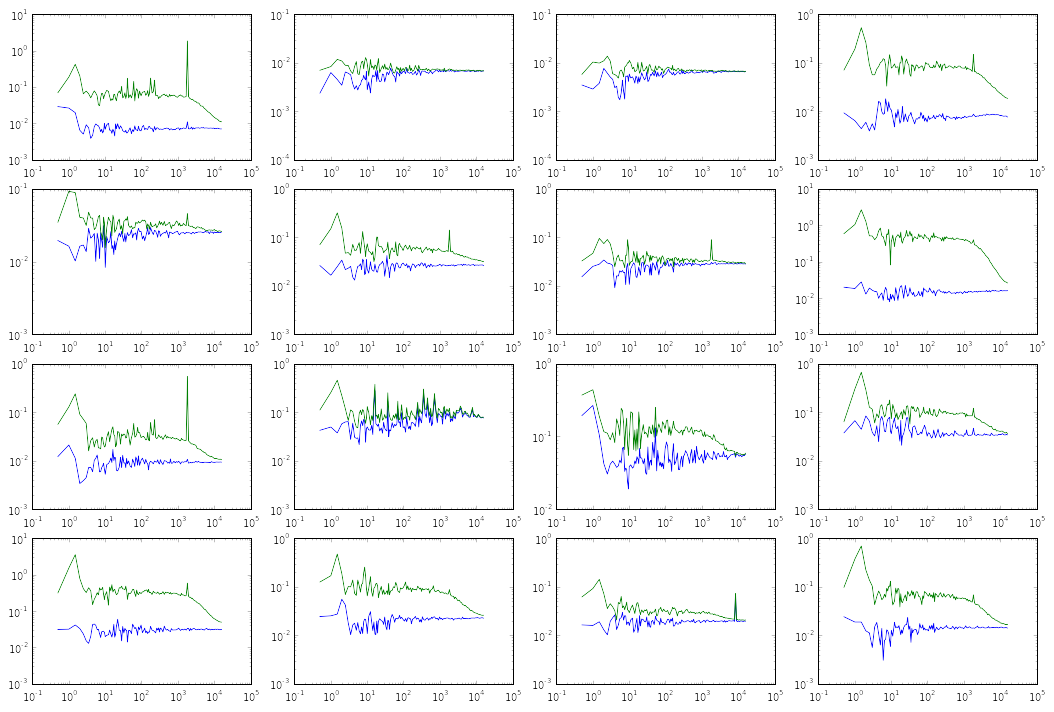

In [31]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)
#    ax.xaxis.set_scale('symlog')

In [76]:
ts = dmod[:,3]
despike = kid_readout.utils.despike.deglitch_window(dmod[:,3]-dmod[:,3].mean(),2**14)

In [79]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

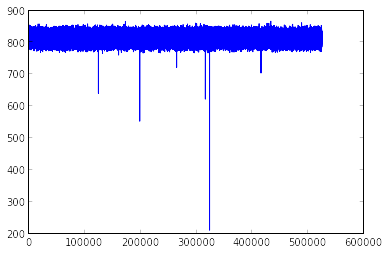

In [68]:
plot(np.abs(ts))

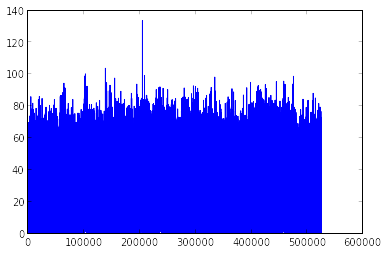

In [74]:
plot(np.abs(despike))

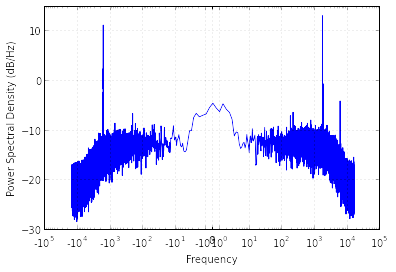

In [77]:
blah = psd(despike,NFFT=2**16,Fs=512e6/2**14)
xscale('symlog')

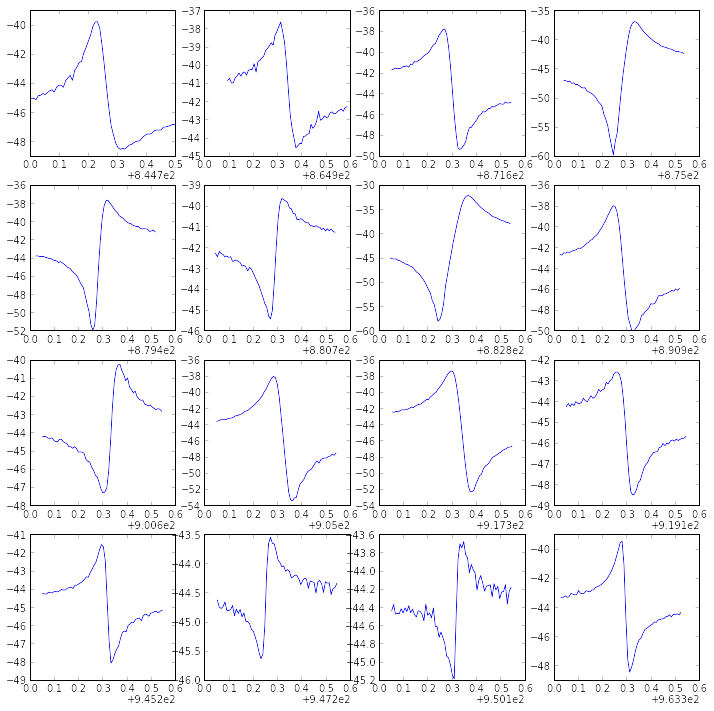

In [124]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    ax.plot(fr,20*np.log10(np.abs(s21)))

In [125]:
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil

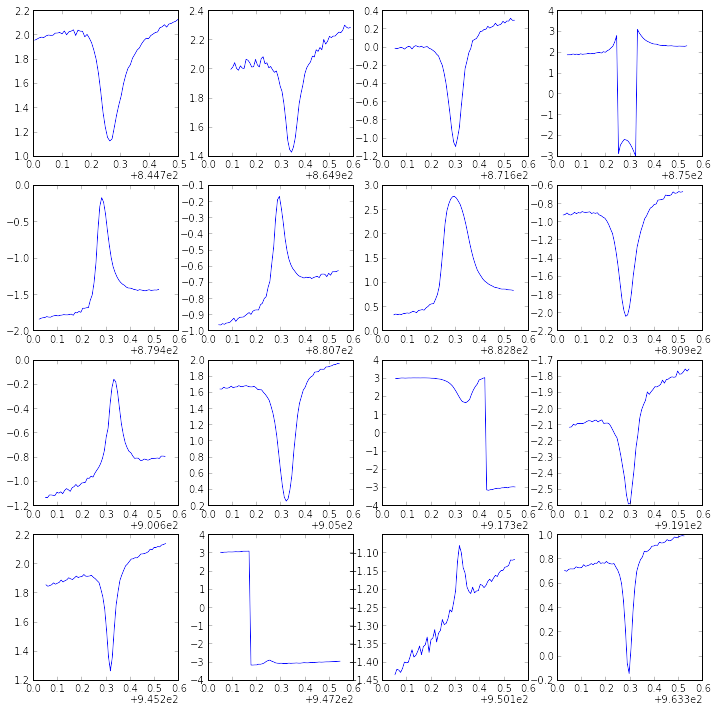

In [126]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(fr,np.angle(s21c))

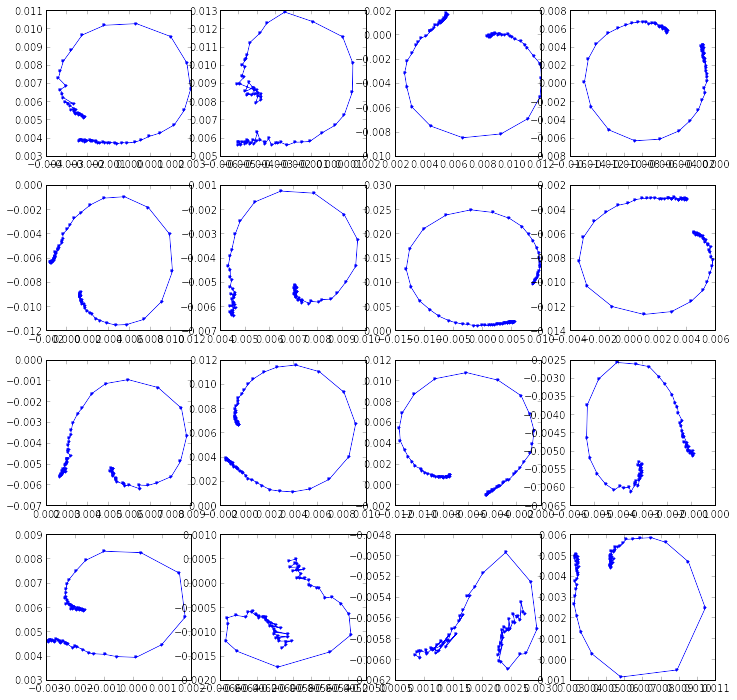

In [127]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(s21c.real,s21c.imag,'.-')

845.1953125 844.703125
14509.7893985 14510.444072 0.472129867535 -12322.2285727 0.0800919642239
865.484375 864.9921875
13217.4273966 13217.884756 0.760819793999 -17047.7298542 0.0100592267738
872.140625 871.6484375
15307.4575411 16953.022477 783.67883999 -11089.3188141 0.000493518101752
875.53125 875.0390625
13887.2248591 31777.5032586 1563.03520456 6009.36525281 0.0160531714692
879.9140625 879.421875
16758.0974406 29862.4133242 3680.38495625 11269.6055095 0.00194483158019
881.234375 880.7421875
16811.7420033 20299.9183079 7482.62873315 26001.8731006 0.00126192586539
883.3359375 882.84375
11713.1545005 28560.3193672 898.400288419 4127.01665023 -0.00358999245783
891.4140625 890.921875
14772.6694893 14773.5314117 0.368098003745 -9654.26705551 0.0142959632228
901.140625 900.6484375
16935.1407938 17823.343019 1244.08575013 20523.9908142 -0.00552956651021
905.5390625 905.046875
16206.3700044 18077.653404 444.903903596 -8334.11105078 0.00199650798053
917.84375 917.3515625
14529.9086211 16900

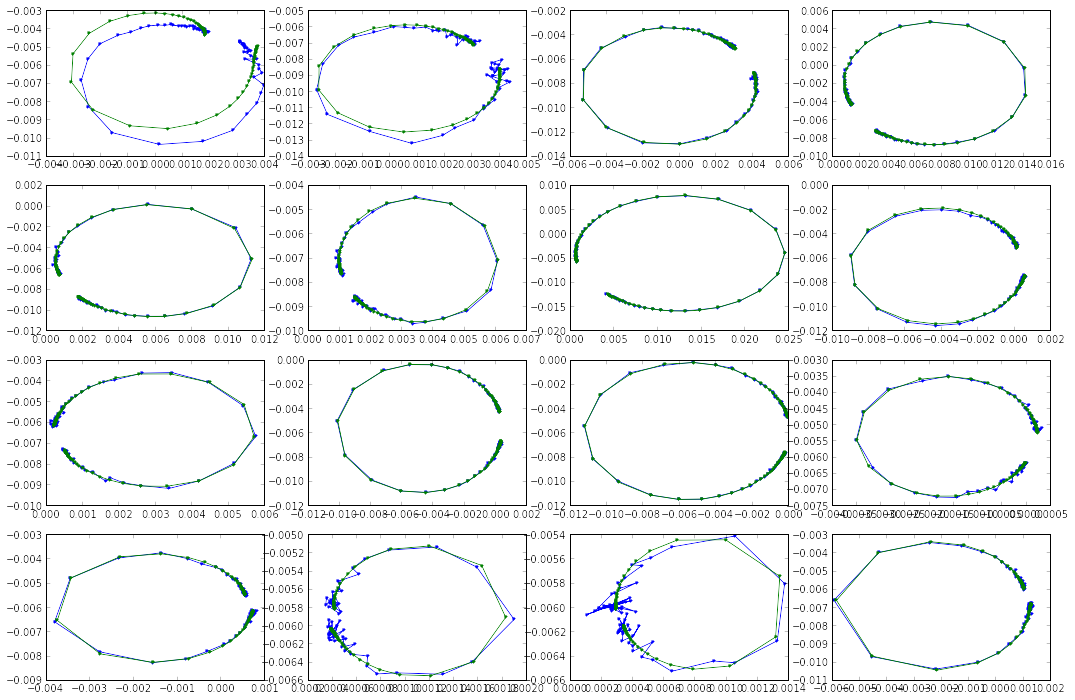

In [132]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
    print fr.max(),fr.min()
    res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
    ax.plot(s21c.real,s21c.imag,'.-')
    modl = res.model(x=fr)
    ax.plot(modl.real,modl.imag,'.-')
    print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
    try:
        ax.set_title(str(res.a))
    except:
        pass

879.9140625 879.421875
16824.6691064 30191.5952085 3740.63904884 11320.6719853 -0.000457328720674


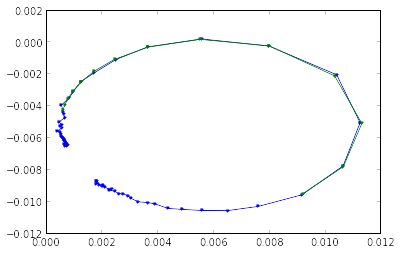

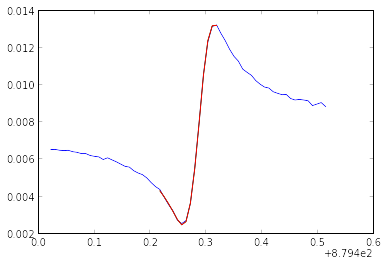

In [129]:
ax = gca()
fr,s21,err = swp.select_index(4)
s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
print fr.max(),fr.min()
res = kid_readout.analysis.resonator.fit_best_resonator(fr[25:-25],s21c[25:-25],errors=err[25:-25],min_a=1.0)
ax.plot(s21c.real,s21c.imag,'.-')
modl = res.model(x=res.freq_data)
ax.plot(modl.real,modl.imag,'.-')
print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
figure()
plot(fr,np.abs(s21c))
plot(res.freq_data,np.abs(modl))
plot(res.freq_data,np.abs(res.model(x=res.freq_data)))


In [96]:
1/(1/res.Q-1/np.abs(res.Q_e_real+1j*res.Q_e_imag))

36322.665100510239

In [97]:
res.Q

13711.847040231984

In [98]:
res.Q_i

15899.183778596402

In [41]:
blks = [blk for blk in swp.blocks if blk.sweep_index==2]

In [42]:
blk = blks[0]

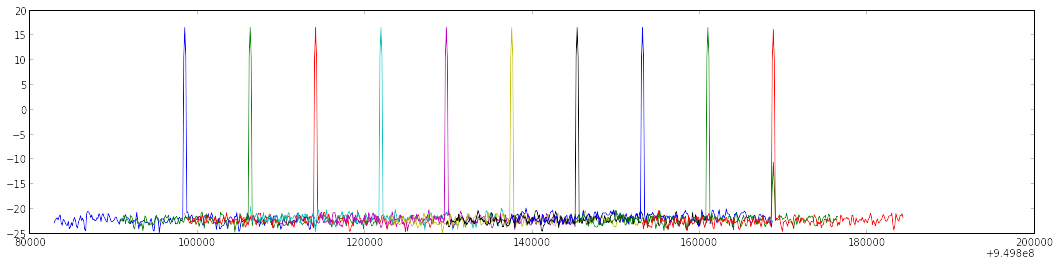

In [52]:
figure(figsize=(18,4))
for blk in blks[:10]:
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))

In [48]:
len(blks)

128

In [53]:
by_index = [[blk for blk in swp.blocks if blk.sweep_index==k] for k in range(16)]

(944000000.0, 951000000.0)

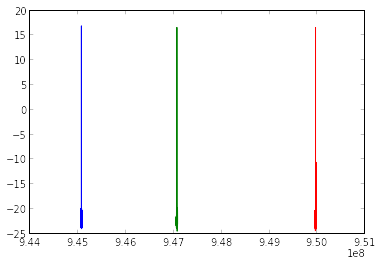

In [58]:
for idx in range(16):
    blk = by_index[idx][8]
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))
xlim(944e6,951e6)

In [60]:
fr,s21,err = swp.select_index(2)

In [61]:
fr.min()

949.8984375

In [62]:
initial_f0s[14:15]

array([ 950.4])

In [63]:
nsamp = 2**16
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s[14:15],offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[ 949.8984375],
       [ 949.90625  ],
       [ 949.9140625],
       [ 949.921875 ],
       [ 949.9296875],
       [ 949.9375   ],
       [ 949.9453125],
       [ 949.953125 ],
       [ 949.9609375],
       [ 949.96875  ],
       [ 949.9765625],
       [ 949.984375 ],
       [ 949.9921875],
       [ 950.       ],
       [ 950.0078125],
       [ 950.015625 ],
       [ 950.0234375],
       [ 950.03125  ],
       [ 950.0390625],
       [ 950.046875 ],
       [ 950.0546875],
       [ 950.0625   ],
       [ 950.0703125],
       [ 950.078125 ],
       [ 950.0859375],
       [ 950.09375  ],
       [ 950.1015625],
       [ 950.109375 ],
       [ 950.1171875],
       [ 950.125    ],
       [ 950.1328125],
       [ 950.140625 ],
       [ 950.1484375],
       [ 950.15625  ],
       [ 950.1640625],
       [ 950.171875 ],
       [ 950.1796875],
       [ 950.1875   ],
       [ 950.1953125],
       [ 950.203125 ],
       [ 950.2109375],
       [ 950.21875  ],
       [ 950.2265625],
       [ 95

In [70]:
ri.set_dac_atten(40)

In [71]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=1)
print time.time()-tic

detected mcnt overflow None 22667977 0 2048 0 16 22667977
55.4558930397


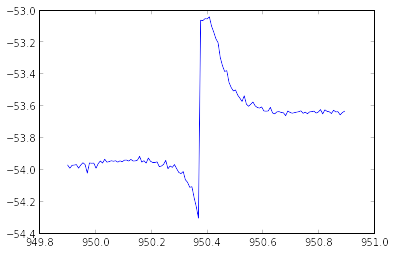

In [72]:
plot(swp.freqs,20*np.log10(np.abs(swp.data)))